## Intro

This is a learning exercise in multivariate regression, implementing a stacked/ensemble regression model, which in theory should be robust to overfitting by combining predictions from multiple regression algorithms with different properties, into one output prediction. This kernel has drawn heavily on the work of others:


* EDA, pre-processing, feature engineering and stacking - Serigne - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

* Original stacking pipeline script - Eike Dehling - https://www.kaggle.com/eikedehling/trying-out-stacking-approaches

* Pipeline for parameter optimisation, for models in a stack/ensemble - 

## Aims
The aim of this challenge is to predict house prices, given a training data set of previous house sales, with a large number of features of the houses sold, from which to train regression models.

## Considerations for Regression Models
Regression is a parametric approach. ‘Parametric’ means it makes assumptions about data for the purpose of analysis. Linear Regression has the following assumptions:
-  Linear relationships
-  Multivariate normality
-  No or little multicollinearity
-  No auto-correlation
-  Homoscedasticity (all variables have same variance)

"Multivariate normality means that regression requires all its variables to be normal. By having skewed data we violate the assumption of normality.

The violations can impact regression in the following ways:
Disproportionate influence on parameter estimates: Parameter estimation is based on the minimization of squared error. observations in skewed data will make a disproportionate effect on the parameter estimates. 
Due to the skewness of data Confidence Intervals (statistics) can be either too wide or too narrow as they are based on the assumption of normally distributed errors.

The assumption of normal distribution is not needed if we are assuming that the equation derived is correct and get the predictions to reduce the RMS.
But if we want to make inferences about the model and also estimate whether a given prediction error will exceed a threshold or not we require the assumptions." See this Quora thread: https://www.quora.com/How-does-skewness-impact-regression-model

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# import some modules from scipy for the calculation of skew and normality and pearsons R value (correlation coeff)

from scipy import stats
from scipy.stats import skew, norm
#from scipy.stats.stats import pearsonr

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})
sns.set_context("paper", font_scale=1.5)

sns.set(rc={'figure.figsize':(11.7,8.27)})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [76]:
train = pd.read_csv('/Users/constar/Documents/GitHub/Data_Science_Portfolio/House_Price_Stacked_Regression_Kaggle/train.csv')
test = pd.read_csv('/Users/constar/Documents/GitHub/Data_Science_Portfolio/House_Price_Stacked_Regression_Kaggle/test.csv')

# Exploratory Data Analysis

In [77]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Right away we can see a mix of categorical and numerical features. Some missing values/sparse features. These will need to be encoded and scaled for a variety of regression algorithms to be fit to the data

In [78]:
train.shape

(1460, 81)

In [79]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

various house features explained here: https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1525345133&Signature=k2Pb6DgaaFeSGEOFZ1lbdnVfM89O3TZ6OUAL3qBIWVfrL%2Bm%2F8FiCs8m7l9PzVfLkMWjRpUIZp6%2FcxQFSUZy2o6TYOB3oSpw1TAd%2Bz3SMNciiU6qCwNx8bCiyImOmSY9kb%2B3EPB9Rrp%2BWzLTSoVIeUxTyThRYHdN%2BjjdoyAbsVFgvirD2RjT1MY3jHENWkB960VnYnwbU94C9kEDryFTmUBKU3XHB1egkM38qTu3qzCMmhSOMpTSph9DDzFog8JGb64%2BaNpcuxkhm7q7xIfQq7%2BGlSR7xl4gO65WDLfQLxwmMSIv1uxiXiR4R6Q%2B64hLE4T9lwpKA3eZEk1U5atEVZg%3D%3D

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

A mix of data types, many very sparse features

In [81]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


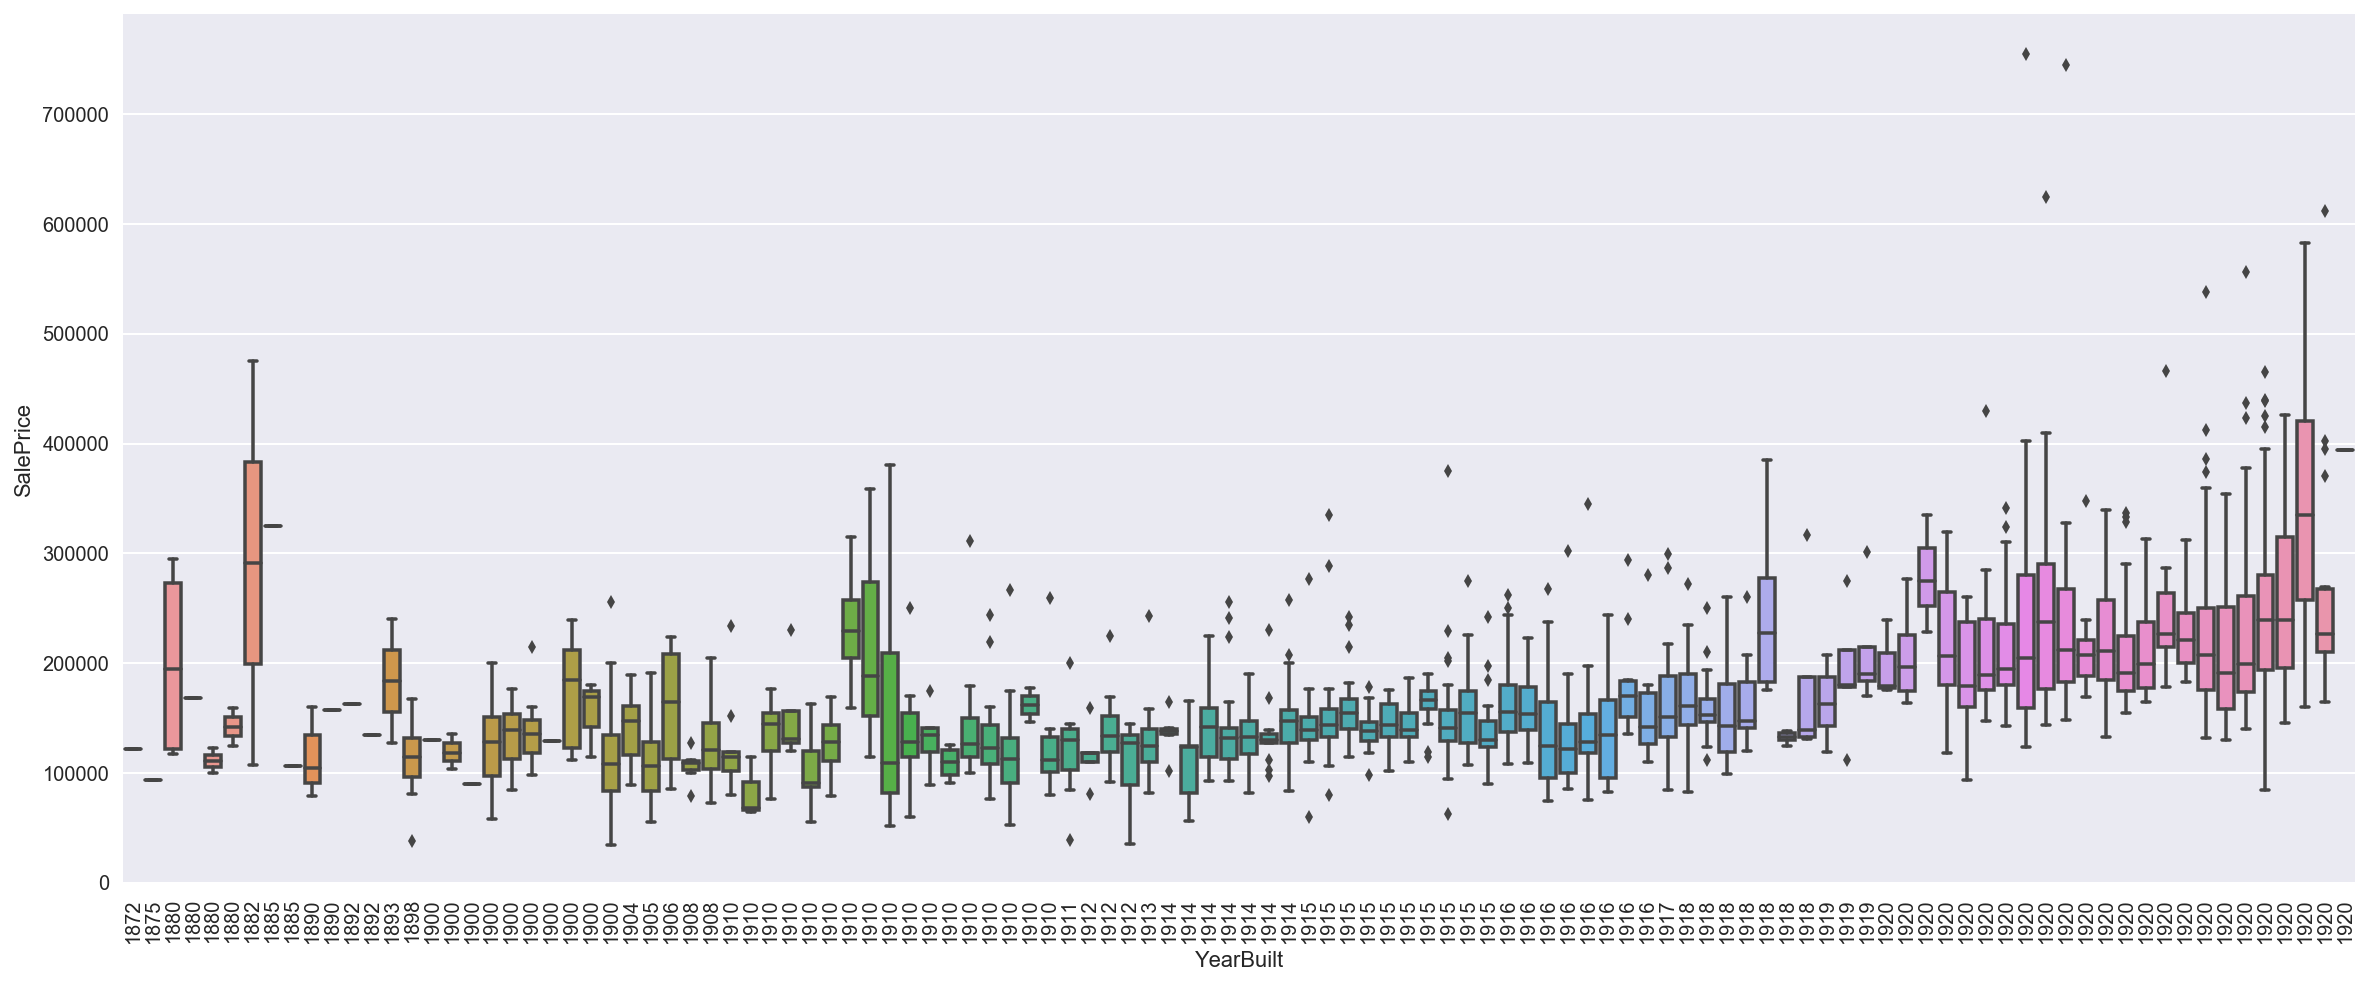

In [99]:
train.sort_values(['YearBuilt'], ascending=[True], inplace=True)
plt.figure(figsize=(20,8))
box_yrblt = sns.boxplot(train.YearBuilt, train.SalePrice).set_xticklabels(train.YearBuilt,rotation=90)

In [92]:
train.YearBuilt.unique()

array([1872, 1875, 1880, 1882, 1885, 1890, 1892, 1893, 1898, 1900, 1904,
       1905, 1906, 1908, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917,
       1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928,
       1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953,
       1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964,
       1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975,
       1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986,
       1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997,
       1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010])

In [ ]:
In this boxplot of all the sale prices by year built we see many skew

In [ ]:
# large feature spaces with lots of positive correlation with the target variable (sale price) 
# and multi-colinearity between features
plt.subplots(figsize=(20,10))
corr = train.corr()
sns.heatmap(corr, cmap = 'RdBu_r', center = 0)

In [ ]:
# inspecting the eigen values (w) and vectors (v) of the correlation coefficients of the various features. 
# Any near zero will indicate strong collinearity
w, v = np.linalg.eig(corr)

In [ ]:
# print the eigen VALUES
w

In [ ]:
# print the eigen VECTORS
v

We have some near zero eigen values therefore there is indeed some collinearity between our features. What do you want me to do about it?

"Remove highly correlated predictors from the model.  If you have two or more factors with a high Variance Inflation Factor (VIF), remove one from the model. Because they supply redundant information, removing one of the correlated factors usually doesn't drastically reduce the R-squared.  Consider using stepwise regression, best subsets regression, or specialized knowledge of the data set to remove these variables. Select the model that has the highest R-squared value. 
 
Use Partial Least Squares Regression (PLS) or Principal Components Analysis, regression methods that cut the number of predictors to a smaller set of uncorrelated components." http://blog.minitab.com/blog/understanding-statistics/handling-multicollinearity-in-regression-analysis

In [ ]:
# combine all data into one data from. By concat on two complete features

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']))

In [ ]:
all_data.shape

In [ ]:
# outliers are reported in the supporting documentation for the dataset, 
#for the sale price and GrLivArea (sq.footage)

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 18)
plt.xlabel('GrLivArea', fontsize = 18)

In [ ]:
#Deleting outliers, which will adversely effect the linear model

train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [ ]:
# outliers eliminated

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize = 18)
plt.xlabel('GrLivArea', fontsize = 18)

In [ ]:
# check the distribution of the target variable Sale Price

sns.distplot(train.SalePrice, fit = norm);

# store the norm fit parameters

(mu, sigma) = norm.fit(train['SalePrice'])

# labelling

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

In [ ]:
# probability distribution plot (QQ plot) for sale price target label
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

So the target variable is not normally distributed. To fit linear models effectively, we must first log transform the data.

In [ ]:
#log transform the target
train['SalePrice'] = np.log1p(train['SalePrice'])

# store the numeric features in a variable
numeric_features = all_data.dtypes[all_data.dtypes !='object'].index

skewed_features = train[numeric_features].apply(lambda x: skew(x.dropna()))

# apply a skew cut-off
skewed_features = skewed_features[skewed_features > 0.75]
skewed_features = skewed_features.index

all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [ ]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot quantile quantile plot anothe test of normality
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [ ]:
ntrain = train.shape[0] # ndarray.shape[0] is the number of rows ndarray.shape[1] is the number of columns
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

In [ ]:
# inspect the percentages of null values in a each column
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
# missing_data.head(20)

In [ ]:
plt.figure(figsize=(7,7))
miss_g = sns.barplot(y = missing_data['Missing Ratio'], x = missing_data.index).set_xticklabels(
    missing_data.index,rotation=90)

## Data Preprocessing: Missing Values > Label Encoding > BoxCox Transformation > Get Dummies

In [ ]:
all_data.BsmtFinSF1.head()

In [ ]:
all_data.Utilities.unique()

In [ ]:
# Dealing with categorical variables with missing values, by setting the missing values to None using a for loop
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond','MSSubClass',"MasVnrType","FireplaceQu",
            "Fence","Alley","MiscFeature","PoolQC"): all_data[col] = all_data[col].fillna('None') 

In [ ]:
all_data.Functional.unique()

In [ ]:
# Fillna in the "Functional" feature column with "Typ". Typical Functionality
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [ ]:
# Dealing with missing values in numerical variables

# The bulk of LotFrontage is not empty so its acceptable to fill with the median
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# numerical features na filled with 0     
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',"MasVnrArea",'MSZoning',
            'Electrical','KitchenQual','Exterior1st', 'Exterior2nd','SaleType'):
    all_data[col] = all_data[col].fillna(0)

In [ ]:
# all_data = all_data.drop(['Utilities'], axis=1)

# encode "Utilities" as an ordinal variable


# AllPub	All public Utilities (E,G,W,& S)	
#        NoSewr	Electricity, Gas, and Water (Septic Tank)
#        NoSeWa	Electricity and Gas Only
#        ELO	Electricity only

all_data.Utilities = all_data.Utilities.fillna('None')

# utilities_ordinal = {"None":0, 'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}

# all_data.Utilities = all_data.Utilities.map(utilities_ordinal)


In [ ]:
# Any missing values left?
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100

all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()                

In [ ]:
# convert some numerical features to categoricals for label encoding
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [ ]:
# use the sklearn LabelEncoder to convert categorical features to one hot representations

from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold', 'Utilities')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

In [ ]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [ ]:
# store the numeric features in a variable
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features. #dropna and sort
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

In [ ]:
 train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

Box Cox transform equation from SciPy documentation

\begin{split}llf(\hat{\lambda}) - llf(\lambda) < \frac{1}{2}\chi^2(1 - \alpha, 1),\end{split}

where llf is the log-likelihood function and χ2 the chi-squared function.

The Box-Cox transform is given by:

y = (x**lmbda - 1) / lmbda,  for lmbda > 0 

    log(x) for lmbda = 0
    
### What does the Box Cox transformation do? 

"Transformations happen by finding the estimate of λ and some values in the neighborhood are chosen to transform the original data.

Once the data is transformed, we assume the data is normally distributed.

The original formula proposed by Box & Cox is:

$y(\lambda) = \left\{
        \begin{array}{ll}
           \frac{y^{\lambda} -1 }\lambda \quad if \lambda \neq 0; \\
            log(y), \quad  if \lambda = 0.
        \end{array}
    \right.$

Which basically turns into choosing λ as a model parameter. This value is found by maximizing log-likelihood."

   

In [ ]:
#boxcox1p rather than log transform all features with skew > 0.75, to make them normally distributed...
# and therefore linearly regressable

# why skew > 0.75 not a different threshold? 

skewness = skewness[abs(skewness) > 0.75] # count up the number of skewed features and print the count
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p # log transform them 
skewed_features = skewness.index
lam = 0.15 # lam refers to the lambda parameter of the box cox transform
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

In [ ]:
# then one hot encode everything
all_data = pd.get_dummies(all_data)
print(all_data.shape)

In [ ]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Base Models

In [ ]:
# Linear regression using Lasso (L1-norm), ElasticNet and Ridge regression (L2-norm) methods 

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

import lightgbm as lgb

from catboost import Pool, CatBoostRegressor

In [ ]:
# Hyperparameter tuning



## RMSLE Root Mean Square Logarithmic Error

Why use this as an error function and not MSE, MAE or RMSE?

$\log{P_i + 1} - \log{A_i +1} = \log{\frac{P_i + 1}{A_i +1}}$

where P is the prediction and A is the actual value.

In case of RMSLE, you take the log of the predictions and actual values. So basically, what changes is the variance that you are measuring. I believe RMSLE is usually used when you don't want to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers.

If both predicted and actual values are small: RMSE and RMSLE is same.
If either predicted or the actual value is big: RMSE > RMSLE
If both predicted and actual values are big: RMSE > RMSLE (RMSLE becomes almost negligible)

Anyway, I believe RMSLE is usually used when you don't want to penalize huge differences in the predicted and true values when both predicted and true values are huge numbers. In these cases only the percentual differences matter since you can rewrite log(Pi + 1) - log(Ai +1) = log((Pi + 1)/(Ai +1)).

For example for P = 1000 and A = 500 would give you the roughly same error as when P = 100000 and A = 50000.

This ideal for house price regression, where the prices become huge numbers and the proportion/percentage of the error is what you care about.

In [ ]:
# specifying cross validation folds including shuffling (stratification necessary also?)

n_folds = 5

def rmsle_cv(model):
    KF = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring = 'neg_mean_squared_error', cv = KF))
    return(rmse)

In [ ]:
# Lasso regression sensitive to outliers. L1-norm regularisation
# sklearn Robustscaler() method on the Lasso pipeline helps.

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))

In [ ]:
# Elastic net is a ratio of L1 and L2 norm regularisation

elastic = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9, random_state = 3))

In [ ]:
# Kernel ridge not plain old ridge

kernelridge = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

Time to get boosted. The tree based models can be used as regressors though they don't extrapolate beyond the range of the training labels very well compared to the previous regressors

In [ ]:
# Gradient boosting regressor.

gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate = 0.05,
                                  max_depth = 4, max_features = 'sqrt',
                                  min_samples_leaf = 15, min_samples_split = 10,
                                  loss='huber', random_state = 5)

In [ ]:
# xgboost the king. Parameters found by Bayesian grid search.
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma = 0.0468,
                            learning_rate = 0.05, max_depth = 3,
                            min_child_weight = 1.7817, n_estimators = 2200,
                            reg_alpha = 0.4640, reg_lambda = 0.8571,
                            subsample = 0.5213, silent = 1,
                            random_state = 7, nthread = -1)

In [ ]:
# Microsofts answer to XGBoost. 
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
SVR_model = make_pipeline(RobustScaler(), SVR())

In [ ]:
# model_catboost = CatBoostRegressor()

In [ ]:
# params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'ctr_border_count':[50,5,10,20,100,200],
#           'thread_count':4}

In [ ]:
# cat_dims = [train.columns.get_loc(i) for i in train.columns] 

In [ ]:
# category_cols[:-1]

In [ ]:
train.columns

In [ ]:
# from sklearn.model_selection import KFold
# from itertools import product,chain

# def catboost_param_tune(params,train,y_train,cat_dims=None,n_splits=3):
#     ps = paramsearch(params)
#     # search 'border_count', 'l2_leaf_reg' etc. individually 
#     #   but 'iterations','learning_rate' together
#     for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
#                       ps.grid_search(['l2_leaf_reg']),
#                       ps.grid_search(['iterations','learning_rate']),
#                       ps.grid_search(['depth'])):
#         res = crossvaltest(prms,train,y_train,cat_dims,n_splits)
#         # save the crossvalidation result so that future iterations can reuse the best parameters
#         ps.register_result(res,prms)
#         print(res,prms,s,'best:',ps.bestscore(),ps.bestparam())
#     return ps.bestparam()

# bestparams = catboost_param_tune(params,train,y_train, cat_dims)

In [ ]:
# score = rmsle_cv(model_catboost)
# print("Catboost score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


In [ ]:
# assess the performance of the regressors using the root mean square logarithmic error

score = rmsle_cv(lasso)
print('\nLasso score : {:.4f} ({:.4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(elastic)
print('ElasticNet score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(kernelridge)
print('Kernel Ridge score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(gboost)
print('Gradient Boosting score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(xgb_model)
print('XGBoost score: {:.4f} ({:4f}) \n'.format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

# to do add SVR

score = rmsle_cv(SVR_model)
print("SVR score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


# Stacking

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [ ]:
# simplest approach to stacking is to average the base models

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
#         define clones of the original models to use in the stacked averaging
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
#         train cloned base models
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])

        return np.mean(predictions, axis = 1)

In [ ]:
# average a few base models

averaged_models = AveragingModels(models = (elastic,gboost, kernelridge, lasso, SVR_model))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
# Adding a meta-model for a more sophisticated stacking

class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
# fit data on clones of the original models
    
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle=True, random_state=156)
        
# train cloned based models and make out of fold (oob) predictions
# needed for the training of the cloned meta-model

        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i , model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
# train the cloned meta-model using out of fold predictions as a new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
#Do the predictions of all base models on the test data and use the averaged predictions as 
#     #meta-features for the final prediction which is done by the meta-model

    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis = 1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (elastic, gboost, kernelridge, SVR_model), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (elastic, gboost, kernelridge), meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

In [ ]:
# final training and prediction

stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

In [ ]:
xgb_model.fit(train, y_train)
xgb_train_pred = xgb_model.predict(train)
xgb_pred = np.expm1(xgb_model.predict(test)) # reverse the log transform with np.expm1, ready for submission
print(rmsle(y_train, xgb_train_pred))

In [ ]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values)) # reverse the log transform with np.expm1, ready for submission
print(rmsle(y_train, lgb_train_pred))

In [ ]:
# model_catboost.fit(train, y_train)
# catboost_train_pred = model_catboost.predict(train)
# catboost_pred = np.expm1(model_catboost.predict(test.values))
# print(rmsle(y_train, catboost_train_pred))

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVR
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import RobustScaler
# from sklearn.pipeline import make_pipeline

# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')

# y_train = np.log1p(train['y'].values)
# id_test = test['ID']

# ##
# # Combine train/test for one-hot-encoding and other transformations
# ##
# num_train = len(train)
# df_all = pd.concat([train, test])
# df_all.drop(['ID', 'y'], axis=1, inplace=True)

# # One-hot encoding of categorical/strings
# df_all = pd.get_dummies(df_all, drop_first=True)

# train = df_all[:num_train]
# test = df_all[num_train:]

# ##
# # Make the pipeline, this allows tuning of parameters of each component via GridsearchCV
# ##
# pipe = make_pipeline(RobustScaler(),
#                      PCA(n_components=0.975),
#                      SVR(kernel='rbf', C=1.0, epsilon=0.05))

# ##
# # Optimize hyper-params, uncomment to tune all of them..
# ##
# gsc = GridSearchCV(
#     estimator=pipe,
#     param_grid={
#         'pca__n_components': (0.95, 0.975, 0.99, None),
#         #'svr__C': (0.5, 1.0, 2.0, 3.0),
#         #'svr__epsilon': (0.01, 0.05, 0.1),
#     },
#     scoring='r2',
#     cv=5
# )

# grid_result = gsc.fit(train, y_train)

# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# for test_mean, test_stdev, train_mean, train_stdev, param in zip(
#         grid_result.cv_results_['mean_test_score'],
#         grid_result.cv_results_['std_test_score'],
#         grid_result.cv_results_['mean_train_score'],
#         grid_result.cv_results_['std_train_score'],
#         grid_result.cv_results_['params']):
#     print("Train: %f (%f) // Test : %f (%f) with: %r" % (train_mean, train_stdev, test_mean, test_stdev, param))

# ##
# # Now train a model with the optimal params we found
# ## 
# pipe.set_params(**grid_result.best_params_)

# pipe.fit(train, y_train)

# y_test = np.expm1(pipe.predict(test))

# df_sub = pd.DataFrame({'ID': id_test, 'y': y_test})
# df_sub.to_csv('mercedes-submission.csv', index=False)